In [2]:
#pip install wordcloud
!pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import shap

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,processed_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control im glad went...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...


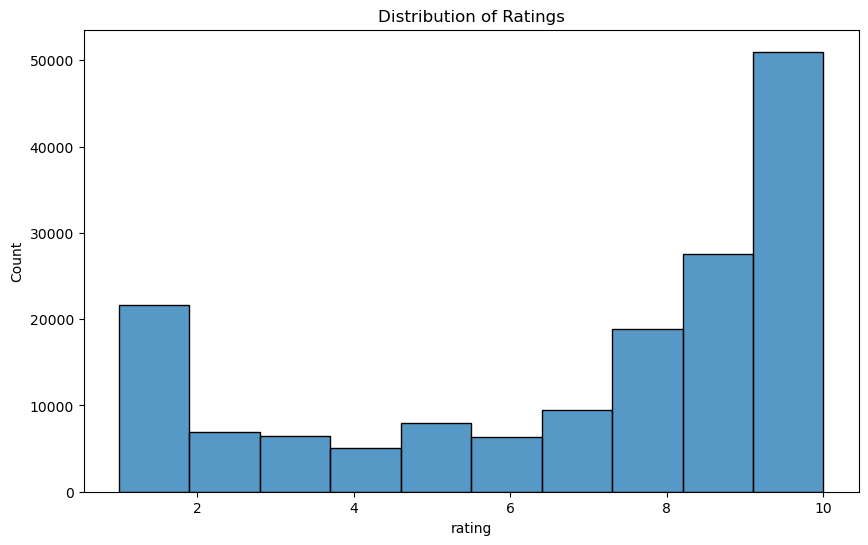

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Distribution of Ratings')
plt.savefig('rating_distribution.png')
plt.show()

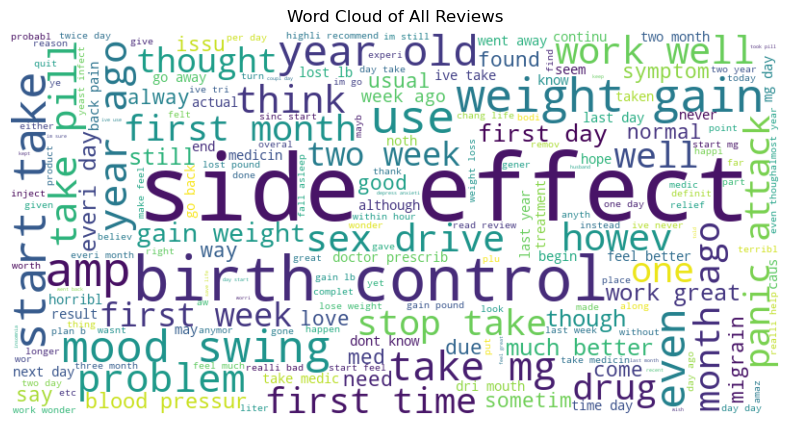

In [8]:
all_words = ' '.join(train_data['processed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Reviews')
plt.savefig('wordcloud.png')
plt.show()

In [9]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_data['processed_review'])
y = train_data['rating']

# GloVe embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")
max_length = 100

[==================================================] 100.0% 128.1/128.1MB downloaded


In [10]:
def text_to_sequence(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_length)

X_glove = text_to_sequence(train_data['processed_review'])

In [11]:
# Split data
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_glove, X_val_glove, _, _ = train_test_split(X_glove, y, test_size=0.2, random_state=42)

In [12]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tfidf, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# LSTM with GloVe embeddings
vocab_size = len(glove_vectors.key_to_index)
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in glove_vectors.key_to_index.items():
    embedding_vector = glove_vectors.get_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_glove, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 185s 51ms/step - accuracy: 0.1362 - loss: -797.3147 - val_accuracy: 0.1348 - val_loss: -2889.7393
Epoch 2/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 181s 50ms/step - accuracy: 0.1335 - loss: -3611.1733 - val_accuracy: 0.1348 - val_loss: -5665.2007
Epoch 3/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 181s 50ms/step - accuracy: 0.1364 - loss: -6386.0312 - val_accuracy: 0.1348 - val_loss: -8444.5732
Epoch 4/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 182s 50ms/step - accuracy: 0.1335 - loss: -9192.7822 - val_accuracy: 0.1348 - val_loss: -11221.8926
Epoch 5/5
3630/3630 ━━━━━━━━━━━━━━━━━━━━ 180s 50ms/step - accuracy: 0.1357 - loss: -11985.3262 - val_accuracy: 0.1348 - val_loss: -13998.5703



Step 5: Model Evaluation

Naive Bayes Performance:
Accuracy: 0.3886
Classification Report:
              precision    recall  f1-score   support

         1.0       0.47      0.52      0.49      4273
         2.0       0.00      0.00      0.00      1375
         3.0       0.33      0.00      0.01      1343
         4.0       1.00      0.00      0.00       970
         5.0       0.32      0.00      0.01      1623
         6.0       0.00      0.00      0.00      1331
         7.0       0.00      0.00      0.00      1945
         8.0       0.27      0.02      0.04      3754
         9.0       0.23      0.08      0.12      5408
        10.0       0.39      0.95      0.55     10238

    accuracy                           0.39     32260
   macro avg       0.30      0.16      0.12     32260
weighted avg       0.32      0.39      0.27     32260



/var/folders/k7/4jxrys1x095bqc5bhnsrf1n00000gn/T/ipykernel_41175/4206840889.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


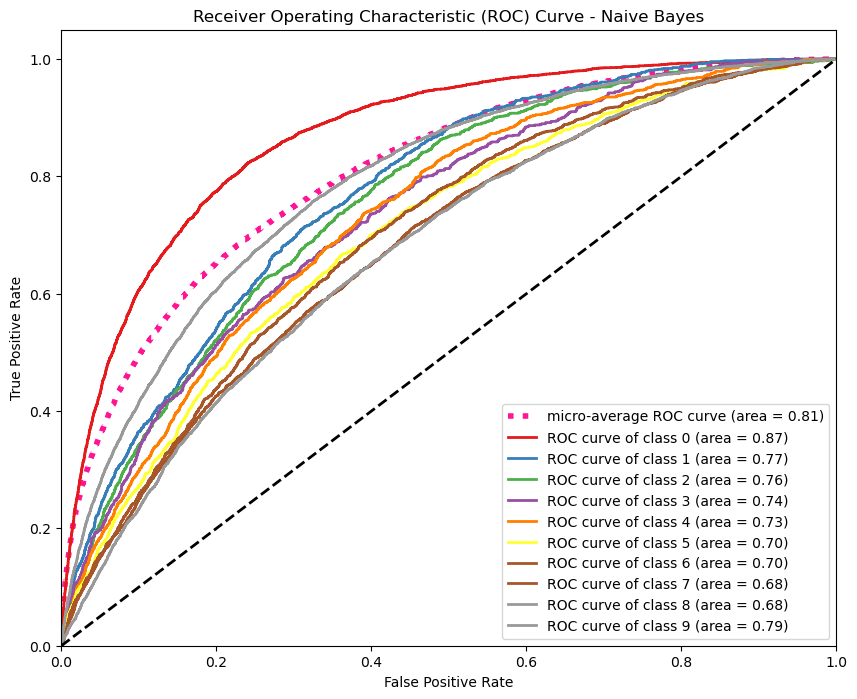

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite


Logistic Regression Performance:
Accuracy: 0.4325
Classification Report:
              precision    recall  f1-score   support

         1.0       0.47      0.73      0.58      4273
         2.0       0.27      0.03      0.06      1375
         3.0       0.24      0.04      0.07      1343
         4.0       0.24      0.02      0.04       970
         5.0       0.22      0.07      0.11      1623
         6.0       0.31      0.03      0.05      1331
         7.0       0.22      0.05      0.08      1945
         8.0       0.25      0.18      0.21      3754
         9.0       0.28      0.22      0.25      5408
        10.0       0.50      0.84      0.63     10238

    accuracy                           0.43     32260
   macro avg       0.30      0.22      0.21     32260
weighted avg       0.36      0.43      0.36     32260



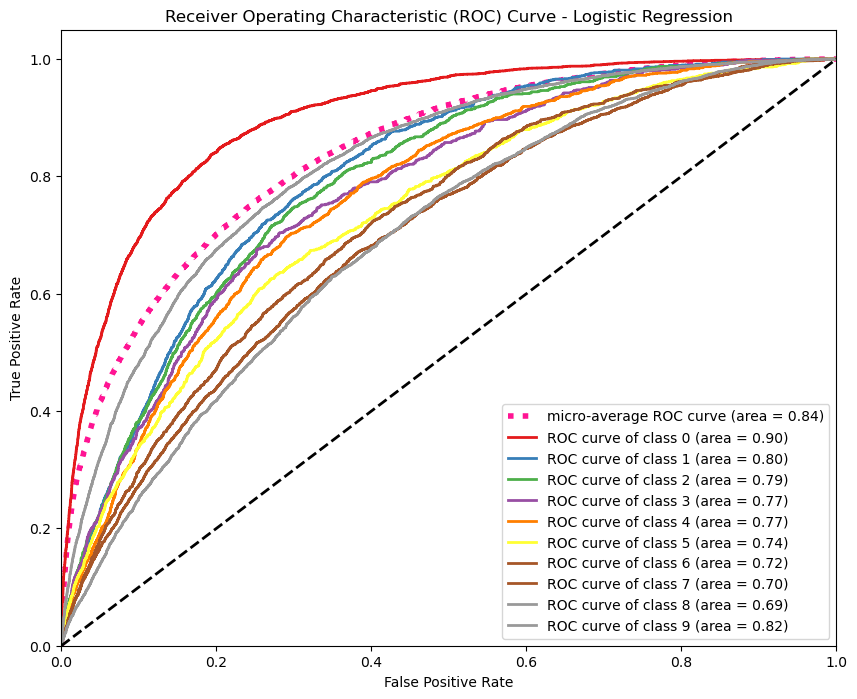


Random Forest Performance:
Accuracy: 0.6782
Classification Report:
              precision    recall  f1-score   support

         1.0       0.72      0.76      0.74      4273
         2.0       0.90      0.49      0.64      1375
         3.0       0.92      0.50      0.65      1343
         4.0       0.88      0.47      0.61       970
         5.0       0.88      0.50      0.64      1623
         6.0       0.89      0.47      0.62      1331
         7.0       0.91      0.48      0.63      1945
         8.0       0.81      0.50      0.62      3754
         9.0       0.74      0.52      0.61      5408
        10.0       0.58      0.95      0.72     10238

    accuracy                           0.68     32260
   macro avg       0.82      0.57      0.65     32260
weighted avg       0.73      0.68      0.67     32260



/var/folders/k7/4jxrys1x095bqc5bhnsrf1n00000gn/T/ipykernel_41175/4206840889.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


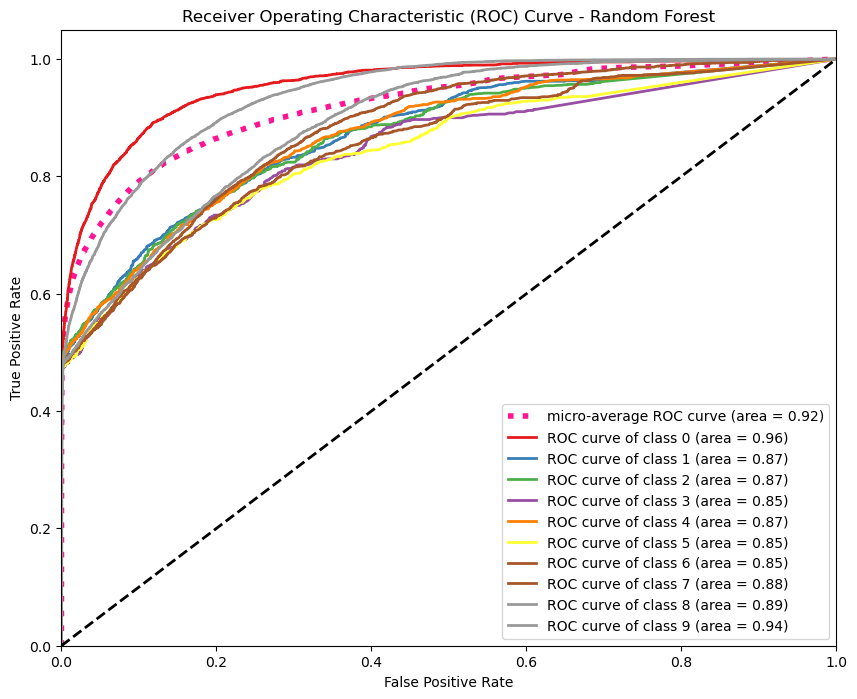

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step

LSTM Performance:
Accuracy: 0.1325
Classification Report:
              precision    recall  f1-score   support

         1.0       0.13      1.00      0.23      4273
         2.0       0.00      0.00      0.00      1375
         3.0       0.00      0.00      0.00      1343
         4.0       0.00      0.00      0.00       970
         5.0       0.00      0.00      0.00      1623
         6.0       0.00      0.00      0.00      1331
         7.0       0.00      0.00      0.00      1945
         8.0       0.00      0.00      0.00      3754
         9.0       0.00      0.00      0.00      5408
        10.0       0.00      0.00      0.00     10238

    accuracy                           0.13     32260
   macro avg       0.01      0.10      0.02     32260
weighted avg       0.02      0.13      0.03     32260



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: multiclass format is not supported

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# 5. Model Evaluation
print("\nStep 5: Model Evaluation")

def evaluate_model(model, X_val, y_val, model_name):
    # For multi-class problems, we need to use OneVsRestClassifier
    if len(np.unique(y_val)) > 2:
        model = OneVsRestClassifier(model)
        model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")
    
    # Compute ROC curve and ROC area for each class
    n_classes = len(np.unique(y_val))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Binarize the output for multi-class ROC
    y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

# Evaluate models
evaluate_model(nb, X_val_tfidf, y_val, "Naive Bayes")
evaluate_model(lr, X_val_tfidf, y_val, "Logistic Regression")
evaluate_model(rf, X_val_tfidf, y_val, "Random Forest")

# Evaluate LSTM
y_pred_lstm = model.predict(X_val_glove)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype("int32")
print("\nLSTM Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lstm_classes):.4f}")
print(f"Classification Report:\n{classification_report(y_val, y_pred_lstm_classes)}")

# ROC curve for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_val, y_pred_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LSTM')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lstm.png')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

# Define parameter grids for optimization
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]  # Example parameters for Naive Bayes
}

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Example parameters for Logistic Regression
    'solver': ['lbfgs', 'liblinear']  # Solvers for Logistic Regression
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in Random Forest
    'max_depth': [None, 10, 20, 30]  # Maximum depth of the trees
}

# Naive Bayes with GridSearchCV
with parallel_backend('threading'):  # or 'threading', depending on your preference
    nb = MultinomialNB()
    nb_grid = GridSearchCV(nb, nb_param_grid, cv=5, n_jobs=-1)
    nb_grid.fit(X_train_tfidf, y_train)

# Logistic Regression with GridSearchCV
with parallel_backend('threading'):
    lr = LogisticRegression(random_state=42)
    lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, n_jobs=-1)
    lr_grid.fit(X_train_tfidf, y_train)

# Random Forest with GridSearchCV
with parallel_backend('threading'):
    rf = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1)
    rf_grid.fit(X_train_tfidf, y_train)

# LSTM with GloVe embeddings remains unchanged
vocab_size = len(glove_vectors.key_to_index)
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in glove_vectors.key_to_index.items():
    embedding_vector = glove_vectors.get_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_glove, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)
